In [1]:
# W. Garrett Levine #
# Yale University   #

# Estimating the Range of Host Masses  #
# for the Peas-in-a-Pod Phenomenon     #

# 08_mutual_hill.ipynb #

# This notebook generates Figure 4.    #

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.stats import pearsonr
from scipy.stats import linregress

from import_data import *

plt.rcParams['font.family'] = 'serif'

# set some constants
earthmass = 5.972E24 # kg
solarmass = 1.989E30 # kg
earthradius = 6.37E8 # cm
solarradius = 6.95E10 # cm

In [2]:
# read the .csv file of moons
moons = pd.read_csv("data/moons.csv")
moons = moons.drop([4, 5]) # DROP THE SMALL URANIAN MOONS (MIRANDA, PUCK)

# must be consistent with the units in Hadden & Lithwick (2017)
# convert the satellite masses to earth masses
moons["Mass_pl"] = moons["Mass_pl"] / earthmass
# convert the moon masses to solar masses
moons["Mass_host"] = moons["Mass_host"] / solarmass
# compute the density of the moons
moons["Density"] = moons["Mass_pl"] * earthmass * 1000\
    / (4*np.pi/3 * (moons["Radius_pl"] * 1.0E5)**3) #g/cm^3

# reset the index to avoid issues in the rest of the notebook
moons = moons.reset_index()
moons = moons.drop("index", axis = 1)

In [3]:
# check on the dataframe
moons.head()

,Moon,Host,Mass_pl,Mass_host,Radius_pl,Radius_host,Period,Semimajor,Density
0,Io,Jupiter,0.014936,0.000905,1821.0,69950,1.769,421800.0,3.526520
1,Europa,Jupiter,0.008038,0.000905,1560.0,69950,3.551,671100.0,3.018414
2,Ganymede,Jupiter,0.024782,0.000905,2631.0,69950,7.155,1070000.0,1.940039
3,Callisto,Jupiter,0.018084,0.000905,2410.0,69950,16.690,1880000.0,1.841976
4,Ariel,Uranus,0.000226,0.000044,578.5,25360,2.520,191000.0,1.664697


In [4]:
# make dataframes for the specific hosts
jupiter = moons[moons["Host"] == "Jupiter"]
saturn = moons[moons["Host"] == "Saturn"]
uranus = moons[moons["Host"] == "Uranus"]

# import the TRAPPIST-1 exoplanets
trappist = pd.read_csv("data/trappist.csv")
trappist["Density"] = trappist["Mass_pl"] * earthmass* 1000\
    / (4*np.pi/3 * (trappist["Radius_pl"] * earthradius)**3) #g/cm^3

In [5]:
# import the TTV planets from Hadden & Lithwick (2017)
hadden = import_hadden()
hosts_hadden_all = hadden["Host"].unique()

mult_all = []

# get the multiplicity of the system
# before applying any "robust" filters
for h in hosts_hadden_all:
    host_df = hadden[hadden["Host"] == h]
    mult = len(host_df)
    for i in range(len(host_df)):
        mult_all.append(mult)

hadden["mult"] = np.array(mult_all)

In [6]:
# filter down to the robust systems
hadden = hadden[hadden["Robust"] == 1]
hosts_hadden = hadden["Host"].unique()

robust_mult = []
# ensure that the multiplicity of the system with
# all of the planets is the same as the multiplicity
# of the "robust" planets
for h in hosts_hadden:
    host_df = hadden[hadden["Host"] == h]
    # get the multiplicity of only the robust planets
    mult = len(host_df)
    for i in range(len(host_df)):
        robust_mult.append(mult)

# add this array as a column to the dataframe
hadden["robustmult"] = np.array(robust_mult)


In [7]:
# filter down to systems with multiple robust planets
hadden = hadden[hadden["mult"] >= 1]
# filter down to systems with all robust planets
hadden = hadden[hadden["mult"] == hadden["robustmult"]]

# get only the robust hosts
robust_hosts = hadden["Host"].unique()

In [8]:
# cut down to only the columns of interest
hadden = hadden[["Name", "Host", "Robust", "P", "R_pl", "M_pl", "rho_pl", "M_st"]]
hadden.head()

,Name,Host,Robust,P,R_pl,M_pl,rho_pl,M_st
0,Kepler-9 b,Kepler-9,1,19.243,8.2,43.5,0.4,1.0
1,Kepler-9 c,Kepler-9,1,38.969,8.3,29.9,0.3,1.0
26,Kepler-30 b,Kepler-30,1,29.323,1.9,8.8,6.7,1.0
27,Kepler-30 c,Kepler-30,1,60.332,13.1,527.7,1.3,1.0
37,Kepler-36 b,Kepler-36,1,13.848,1.5,3.9,7.0,1.0


In [9]:
# for comparative purposes, add the mass-radius
# relationship used by Weiss et al. (2018)
def infer_mass(r_pl):
    """
    r_pl -- Earth radii
    mass -- Earth masses
    """
    # infer the and density mass of a planet
    # from its radius given Equations 6-9
    # in Weiss et al. (2018)
    if r_pl < 1.5:
        density = 2.43 + 3.39*(r_pl) #g/cm^3
        return(density / 5.51) * (r_pl)**3
    elif 1.5 <= r_pl <= 4.0:
        return 2.69*(r_pl)**(0.93)
    elif 4.0 < r_pl < 9.0:
        return 0.86*(r_pl)**(1.89)
    else:
        return 100

In [10]:
# assign masses to the TTV planets based
# on the relationship from Weiss et al. (2018)

weissmasses = []
for i in range(len(hadden)):
    planet = hadden.iloc[i]
    weissmasses.append(infer_mass(planet["R_pl"]))
    
hadden["weissmass"] = np.array(weissmasses)

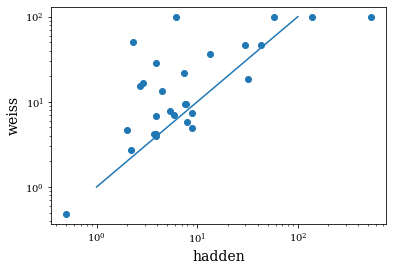

In [11]:
# generate a quick scatter plot to see how well
# the masses match each other
fig, ax = plt.subplots()
ax.scatter(hadden["M_pl"], hadden["weissmass"])
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("hadden", fontsize = 14)
ax.set_ylabel("weiss", fontsize = 14)

ax.plot(np.linspace(1, 100, 2), np.linspace(1, 100, 2))

In [12]:
# define the formula for spacing in mutual Hill radii
def mutual_hill(m_in, m_out, m_st, p_in, p_out):
    # Weiss et al. (2018) Equation 5
    fancy_P = p_out / p_in
    return 2 * ((3 * m_st) / (m_in + m_out))**(1/3)  * (fancy_P**(2/3) - 1) / (fancy_P**(2/3) + 1)

In [13]:
# compute the spacing for the Hadden & Lithwick (2017) planets

peatohost_hadden = []
mutual_hill_hadden = []

# take only the hosts with all robustly-determined masses
for h in robust_hosts:
    # filter down to the rows for the given host
    host_df = hadden[hadden["Host"] == h]
    # sort the host dataframe by period
    host_df = host_df.sort_values(by = "P")
    
    # compute the mutual_hill radius for each pair
    for i in range(len(host_df) - 1):
        inner = host_df.iloc[i]
        outer = host_df.iloc[i+1]
        
        # kg for all of the inner/outer/host masses
        # units will cancel in spacing formula
        inner_mass = inner["M_pl"] * earthmass
        outer_mass = outer["M_pl"] * earthmass
        host_mass = inner["M_st"] * solarmass
        # periods in days for both inner/outer period
        # units will cancel in spacing formula
        inner_period = inner["P"]
        outer_period = outer["P"]
        
        # compute the mutual Hill radii
        Delta = mutual_hill(inner_mass, outer_mass, host_mass, inner_period, outer_period)
        
        # print off the data so that we can spot-check a few values
        print(inner["Name"], outer["Name"]) 
        print("Masses: ", inner["M_pl"], outer["M_pl"]) 
        print("Periods: ", inner_period, outer_period)
        print("Spacing: ", round(Delta, 2))
        print()
        
        peamasses = (inner_mass + outer_mass) / 2
        peatohost_hadden.append((peamasses)/ host_mass)
        mutual_hill_hadden.append(Delta)   

Kepler-9 b Kepler-9 c
Masses:  43.5 29.9
Periods:  19.243 38.969
Spacing:  11.03

Kepler-30 b Kepler-30 c
Masses:  8.8 527.7
Periods:  29.323 60.332
Spacing:  5.81

Kepler-36 b Kepler-36 c
Masses:  3.9 7.5
Periods:  13.848 16.233
Spacing:  4.7

Kepler-49 b Kepler-49 c
Masses:  8.0 5.9
Periods:  7.204 10.913
Spacing:  9.08

Kepler-51 b Kepler-51 c
Masses:  2.3 3.9
Periods:  45.155 85.316
Spacing:  23.48

Kepler-51 c Kepler-51 d
Masses:  3.9 6.2
Periods:  85.316 130.18
Spacing:  13.36

Kepler-56 b Kepler-56 c
Masses:  32.0 137.6
Periods:  10.501 21.405
Spacing:  9.42

Kepler-60 b Kepler-60 c
Masses:  3.7 2.0
Periods:  7.133 8.919
Spacing:  8.32

Kepler-60 c Kepler-60 d
Masses:  2.0 3.9
Periods:  8.919 11.899
Spacing:  10.6

Kepler-89 c Kepler-89 d
Masses:  7.8 58.4
Periods:  10.424 22.343
Spacing:  12.69

Kepler-177 b Kepler-177 c
Masses:  5.4 13.5
Periods:  36.855 49.412
Spacing:  7.31

Kepler-279 c Kepler-279 d
Masses:  7.4 4.5
Periods:  35.735 54.414
Spacing:  12.96

Kepler-307 b Kepl

In [14]:
mutual_hill_jupiter = []
mutual_hill_trappist = []
mutual_hill_uranus = []

peatohost_jupiter = []
peatohost_trappist = []
peatohost_uranus = []

# do the same computation for the Jovian
# Uranian, and TRAPPIST-1 systems

for i in range(len(jupiter) - 1):
        inner = jupiter.iloc[i]
        outer = jupiter.iloc[i+1]
        
        inner_mass = inner["Mass_pl"] * earthmass
        outer_mass = outer["Mass_pl"] * earthmass
        host_mass = inner["Mass_host"] * solarmass
        inner_period = inner["Period"]
        outer_period = outer["Period"]
        
        Delta = mutual_hill(inner_mass, outer_mass, host_mass, inner_period, outer_period)
        
        # print for spot-checking purposes
        # (can check in Wolfram Alpha)
        print(inner["Moon"], outer["Moon"], round(Delta, 2))
        
        peamasses = (inner_mass + outer_mass) / 2
        peatohost_jupiter.append((peamasses)/ host_mass)
        mutual_hill_jupiter.append(Delta)

print()
for i in range(len(uranus) - 1):
        inner = uranus.iloc[i]
        outer = uranus.iloc[i+1]
        
        inner_mass = inner["Mass_pl"] * earthmass
        outer_mass = outer["Mass_pl"] * earthmass
        host_mass = inner["Mass_host"] * solarmass
        inner_period = inner["Period"]
        outer_period = outer["Period"]
        
        Delta = mutual_hill(inner_mass, outer_mass, host_mass, inner_period, outer_period)
        print(inner["Moon"], outer["Moon"], round(Delta, 2))
        
        peamasses = (inner_mass + outer_mass) / 2
        peatohost_uranus.append((peamasses)/ host_mass)
        mutual_hill_uranus.append(Delta)

print()
for i in range(len(trappist) - 1):
        inner = trappist.iloc[i]
        outer = trappist.iloc[i+1]
        
        inner_mass = inner["Mass_pl"] * earthmass
        outer_mass = outer["Mass_pl"] * earthmass
        host_mass = inner["Mass_host"] * solarmass
        inner_period = inner["Period"]
        outer_period = outer["Period"]
        
        Delta = mutual_hill(inner_mass, outer_mass, host_mass, inner_period, outer_period)
        print(inner["Pea"], outer["Pea"]) 
        print("Masses: ", inner["Mass_pl"], outer["Mass_pl"]) 
        print("Periods: ", inner_period, outer_period)
        print("Spacing: ", round(Delta, 2))
        print()
        
        
        peamasses = (inner_mass + outer_mass) / 2
        peatohost_trappist.append((peamasses)/ host_mass)
        mutual_hill_trappist.append(Delta)

Io Europa 15.52
Europa Ganymede 13.86
Ganymede Callisto 15.2

Ariel Umbriel 15.42
Umbriel Titania 18.5
Titania Oberon 9.84

b c
Masses:  1.37 1.31
Periods:  1.511 2.422
Spacing:  9.68

c d
Masses:  1.31 0.388
Periods:  2.422 4.049
Spacing:  12.25

d e
Masses:  0.388 0.692
Periods:  4.049 6.1
Spacing:  11.4

e f
Masses:  0.692 1.04
Periods:  6.1 9.201
Spacing:  9.77

f g
Masses:  1.04 1.32
Periods:  9.201 12.35
Spacing:  6.33

g h
Masses:  1.32 0.326
Periods:  12.35 18.76
Spacing:  10.1



In [15]:
print(len(peatohost_hadden))

15


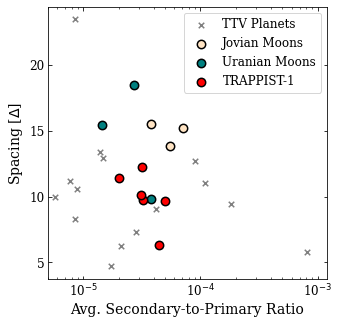

In [16]:
# plot the figure of the spacing in mutual Hill radii
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(5)

# plot the Hadden & Lithwick (2017) peas
ax.scatter(peatohost_hadden, mutual_hill_hadden,\
    c = "grey", s = 30, label = "TTV Planets", marker = "x")

# plot the low mass candidate pods
ax.scatter(peatohost_jupiter, mutual_hill_jupiter,\
    edgecolors = "black", s = 70, label = "Jovian Moons", marker = "o", facecolors = "bisque", linewidths = 1.5)
ax.scatter(peatohost_uranus, mutual_hill_uranus,\
    edgecolors = "black", s = 70, label = "Uranian Moons", marker = "o", facecolors = "teal", linewidths = 1.5)
ax.scatter(peatohost_trappist, mutual_hill_trappist,\
    edgecolors = "black", s = 70, label = "TRAPPIST-1", marker = "o", facecolors = "red", linewidths = 1.5)

# set the x-axis scale to log
ax.set_xscale("log")
# set the x-axis limits
ax.set_xlim(5.0E-6, 1.2E-3)

# generate a legend
ax.legend(fontsize = 12)

# set the tick parameter font size
ax.tick_params(axis='both', which='major', labelsize=12)

# set the x-axis ticks and ticklabels
ax.set_xticks([1.0E-5, 1.0E-4, 1.0E-3])
ax.set_xticklabels(["10$^{-5}$", "10$^{-4}$", "10$^{-3}$"])

# set the y-axis ticks and ticklabels
ax.set_yticks([5, 10, 15, 20])
ax.set_yticklabels(["5", "10", "15", "20"])

# set the axis labels
ax.set_xlabel("Avg. Secondary-to-Primary Ratio", fontsize = 14)
ax.set_ylabel("Spacing [$\\Delta$]", fontsize = 14)

ax.tick_params(axis="y",direction="in", which="both")
ax.tick_params(axis="x",direction="in", which="both")

ax.tick_params(bottom=True, top = True, left = True, right = True, which = "both")

# save the figure
saveFigure = False
if saveFigure: plt.savefig("mutualhill.png", dpi = 800)